# tsGT Training

This script contains all necessary code for training the tsGT models used in the experiments. After training, a prediction procedure for all models is carried out in order to get all necessary results that are to be used in estimation. 

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import sys
sys.path.append('code')

import predictors
import inputs
import models
import trainer
import datasets as ds

import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from trax import optimizers
import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.WARNING)
import trax
import glob
import re

2026-02-09 22:54:31.754109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/xristos/miniconda3/envs/jax_legacy/lib/python3.9/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional infor

## Dataset Loading
First, the datasets that are to be used for training need to be imported. These datasets are created in the "Synthetic Data Generation" notebook and amount to a dictionary containing the three datasets. The created synthetic datasets can be found at "data/synthetic_datasets.pkl" and were created in another environment to avoid conflicting libraries.


In [9]:
import pickle
with open('data/synthetic_datasets_segments.pkl', 'rb') as file:
    samples = pickle.load(file)

In [10]:
def data_do_df(samples, start_date='2018-01-01 00:00:00', freq='1h'):
    " Utility function to map a dataset to a dataframe. Covariates here don't matter and are dropped during training."
    n_signals, length = samples.shape
    df = pd.DataFrame(samples.T)
    df.index = pd.date_range(start_date, periods=length, freq=freq)
    df.index.name = 'date'
    return df

# Training
Training is carried out across fixed seeds in order to keep results reproducible. 10 models are trained to account for variability during training.

## Data normalization and clipping
As the data gets normalized first and then mapped to [0,1], we first need to figure out the minimum and maximum representable values in the data. To do, since we normalize per time series we can use the following code. This tells us the low and high parameters in the predictor, which represent the maximun range of normalized parameters we can expect. We calculate this on the whole dataset.

In [107]:
from predictors.normalization import PerTsNormalizer
normalizer = PerTsNormalizer(regularizer=0.001) # same value as the normalization_regularizer passed to the predictor
norm_data, _, _ = normalizer.normalize(samples["dgp_dataset"]["samples"])
print(f"Normalized range: [{norm_data.min():.2f}, {norm_data.max():.2f}]")

Normalized range: [-5.00, 5.17]


In [ ]:
from trax.supervised import lr_schedules
import functools

lr_schedule = functools.partial(
    lr_schedules.multifactor,
    constant=0.03,
    factors='constant * linear_warmup * rsqrt_decay',
    warmup_steps=1000
)
seeds = [3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049]
for seed in seeds:
    # Use 80% for training
    signals = samples["dgp_dataset"]["samples"]
    signal_length = 1024
    n_signals = int(0.8*len(signals))
    n_steps = 5000
    start_date = pd.Timestamp('2018-01-01 00:00:00')
    freq = '1h'
    train_window = 896     
    eval_window = 128         
    series_length = 256
    batch_size = 16

    # create a dataframe for the data
    df = data_do_df(signals[:n_signals], start_date=start_date, freq=freq)

    dataset = ds.Dataset(
        data_full=ds.DataCollection(data_loader=lambda: df),
        start_date=start_date,
        train_window=train_window,
        eval_window=eval_window,
        series_length=series_length,
    )
    inputs_iterable = functools.partial(
        inputs.CreateInputs,
        dataset=dataset,
        batch_size=batch_size,
        series_length=series_length,
        weighted_sampling=False,
        traxify=True
    )
    model_body = functools.partial(
    models.TransformerBody,
        d_model=128,     
        d_ff_mul=2,
        n_layers=4,         
        n_heads=4,
        max_len=2048,
        dropout=0.1,
        ff_activation=trax.layers.FastGelu,
    )
    predictor_class = functools.partial(
        predictors.SerialPredictor,
        d_in=128,           
        vocab_size=10,      
        precision=3,        
        significance_decay=0.3,  
        low=-6.0,
        high=6.0,
        normalization="per_ts",
        normalization_regularizer=0.001
    )
    loop, predictor = trainer.train(
        output_dir=f'./out/training_result/segmented{seed}_2',
        inputs=functools.partial(inputs_iterable, full_eval=False),
        model_body=model_body,
        predictor_class=predictor_class,
        optimizer=optimizers.Adam,
        lr_schedule=lr_schedule,
        n_steps=n_steps,     
        eval_every=100,
        n_eval_batches=32,
        calc_eval_loss=True,
        seed=seed
    )

## Predictions
After training, we are able to reconstruct the predictor and pass the weights back into it to get the predictions conditioned on a predefined context.

First, we define a function to load model weights from the latest checkpoint.

In [4]:
import gzip
import jax
import io
import pickle
import numpy as np
import functools

In [5]:
def load_structured_weights(weights_path):
    """Trax checkpoints save flattened weights, therefore we need to reconstruct their structure. To make things easier, we save the weights of a model
    with the same hyperparameters and use its weights to reconstruct the weight structure. This file is provided with the code."""
    
    with gzip.open(weights_path, 'rb') as f:
        content = f.read()
    # First get the flattened arrays from the gz file.
    buffer = io.BytesIO(content)
    arrays = []
    while buffer.tell() < len(content):
        try:
            arr = np.load(buffer, allow_pickle=True)
            arrays.append(arr)
        except ValueError as e:
            print(e)
            break
        except EOFError:
            break
    # Now get the nested weight structure.
    with gzip.open("eval_model_weights.pkl.gz", "rb") as f:
        weights = pickle.load(f)
    # use jax's tree utils, useful...
    structure = jax.tree_util.tree_structure(weights)
    reconstructed_weights = jax.tree_util.tree_unflatten(structure, arrays)
    if jax.tree_util.tree_structure(reconstructed_weights) == structure:
        print("Weight structure reconstructed succesfully")
    return reconstructed_weights

Now we need to reconstruct the predictor and a model that needs to be passed to the predictor. These can be rebuilt using the same hyperparameters as they do not contain any relevant internal states. Instead, we will pass the weights to the predictor later on.

In [6]:
def reconstruct_predictor():
    """Reconstructs the predictor with the same settings used during training."""
    model_body = functools.partial(
        models.TransformerBody,
            d_model=128,     
            d_ff_mul=2,
            n_layers=4,         
            n_heads=4,
            max_len=2048,
            dropout=0.1,
            ff_activation=trax.layers.FastGelu,
        )
    predictor = predictors.SerialPredictor(
        model_body_fn=model_body,
        d_in=128,
        vocab_size=10,
        precision=3,
        significance_decay=0.3,
        low=-6.0,
        high=6.0,
        normalization="per_ts",
        normalization_regularizer=0.001
    )
    return predictor

In [7]:
def make_predictions(context, weights, pred_len, predictor, batch_size=16):
    """Use the predictor and a context of [n_series, context] to make predictions."""
    n_series = context.shape[0]
    all_predictions = []
    
    for start in range(0, n_series, batch_size):
        end = min(start + batch_size, n_series)
        batch_context = context[start:end]
        actual_size = batch_context.shape[0] # Remember if batch size <16
        
        # Since predictor needs to be initialised with batch_size, if we run out of batches of 16 just pad and then drop.
        if actual_size < batch_size:
            padding = np.zeros((batch_size - actual_size, batch_context.shape[1]))
            batch_context = np.concatenate([batch_context, padding], axis=0)
        
        context_length = batch_context.shape[1]
        total_length = context_length + pred_len
        inputs = np.zeros((batch_size, total_length, 1), dtype=np.int32)
        
        predictions = predictor.predict(
            weights=weights, 
            context=batch_context, 
            horizon_length=pred_len, 
            inputs=inputs
        )
        full_series = np.concatenate([batch_context, predictions], axis=1)
        
        # remove the padded series here, we just need them to initialise the predictor.
        full_series = full_series[:actual_size]
        all_predictions.append(full_series)
    
    return np.concatenate(all_predictions, axis=0)

## Results
We can now create and save the prediction results.

In [13]:
with open('data/synthetic_datasets_segments.pkl', 'rb') as file:
    samples = pickle.load(file)

### In-segment predictions

In [294]:
seeds = [3040 + i for i in range(10)]
results = {}
for seed in seeds:
    results[seed] = {}
    # Load the model's weights based on seed.
    weights = load_structured_weights(f"out/training_result/segmented{seed}_2/model_5000.weights.npy.gz") # only grab the latest state
    predictor = reconstruct_predictor()
    # Get the last 205 sequences from the dataset.
    signals = samples["dgp_dataset"]["samples"][819:,]
    for i in range(4):
        seg_start = i*256
        seg_end = seg_start + 256
        context_end = seg_start + 128
        contexts = signals[:, seg_start:context_end]

        # Predict the next 128 to make sure we stay within the segment
        series = make_predictions(contexts, weights, 128, predictor)
        results[seed][f"segment{i+1}"] = series
        print(f"Finished with {seed}, segment {i+1}")
        
with open("out/predictions/in_segment.pkl", "wb") as f:
    pickle.dump(results, f)

Weight structure reconstructed succesfully
Finished with 3040, segment 1
Finished with 3040, segment 2
Finished with 3040, segment 3
Finished with 3040, segment 4
Weight structure reconstructed succesfully
Finished with 3041, segment 1
Finished with 3041, segment 2
Finished with 3041, segment 3
Finished with 3041, segment 4
Weight structure reconstructed succesfully
Finished with 3042, segment 1
Finished with 3042, segment 2
Finished with 3042, segment 3
Finished with 3042, segment 4
Weight structure reconstructed succesfully
Finished with 3043, segment 1
Finished with 3043, segment 2
Finished with 3043, segment 3
Finished with 3043, segment 4
Weight structure reconstructed succesfully
Finished with 3044, segment 1
Finished with 3044, segment 2
Finished with 3044, segment 3
Finished with 3044, segment 4
Weight structure reconstructed succesfully
Finished with 3045, segment 1
Finished with 3045, segment 2
Finished with 3045, segment 3
Finished with 3045, segment 4
Weight structure recon

### Cross-segment predictions

In [295]:
seeds = [3040 + i for i in range(10)]
results = {}
for seed in seeds:
    results[seed] = {}
    # Load the model's weights based on seed.
    weights = load_structured_weights(f"out/training_result/segmented{seed}_2/model_5000.weights.npy.gz") # only grab the latest state
    predictor = reconstruct_predictor()
    # Get the last 205 sequences from the dataset.
    signals = samples["dgp_dataset"]["samples"][819:,]
    for i in range(3):
        seg_start = i*256
        seg_end = seg_start + 256
        context_end = seg_start + 256
        contexts = signals[:, seg_start:context_end]

        # Predict the next 256 to make sure we stay within the segment
        series = make_predictions(contexts, weights, 256, predictor)
        results[seed][f"segment{i+1}"] = series
        print(f"Finished with {seed}, segment {i+1}")
        
with open("out/predictions/cross_segment.pkl", "wb") as f:
    pickle.dump(results, f)

Weight structure reconstructed succesfully
Finished with 3040, segment 1
Finished with 3040, segment 2
Finished with 3040, segment 3
Weight structure reconstructed succesfully
Finished with 3041, segment 1
Finished with 3041, segment 2
Finished with 3041, segment 3
Weight structure reconstructed succesfully
Finished with 3042, segment 1
Finished with 3042, segment 2
Finished with 3042, segment 3
Weight structure reconstructed succesfully
Finished with 3043, segment 1
Finished with 3043, segment 2
Finished with 3043, segment 3
Weight structure reconstructed succesfully
Finished with 3044, segment 1
Finished with 3044, segment 2
Finished with 3044, segment 3
Weight structure reconstructed succesfully
Finished with 3045, segment 1
Finished with 3045, segment 2
Finished with 3045, segment 3
Weight structure reconstructed succesfully
Finished with 3046, segment 1
Finished with 3046, segment 2
Finished with 3046, segment 3
Weight structure reconstructed succesfully
Finished with 3047, segmen

# Training/val loss curves

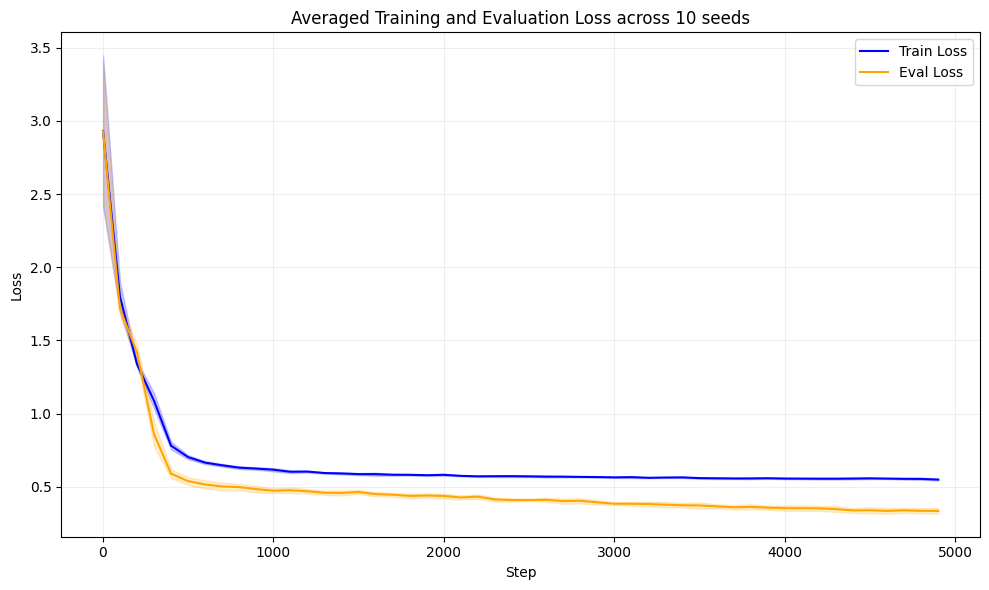

In [53]:
# Reimport after training...
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import trax

seeds = [3040 + i for i in range(10)]
all_train_losses = []
all_eval_losses = []
for seed in seeds:
    checkpoint_file = f'out/training_result/segmented{seed}_2/model_5000.pkl.gz'
    # Load the model checkpoint to get the losses, these are in the model_{steps}.pkl.gz files...
    with gzip.open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
    
    # These are basically stored in a custom trax class which has everything we need.
    train_losses = checkpoint['history']['_values']['train']['metrics/WeightedCategoryCrossEntropy']
    eval_losses = checkpoint['history']['_values']['eval']['metrics/WeightedCategoryCrossEntropy']
    # We can make these into a normal dict for ease of access.
    train_dict = {step: float(loss) for step, loss in train_losses}
    eval_dict = {step: float(loss) for step, loss in eval_losses}
    all_train_losses.append(train_dict)
    all_eval_losses.append(eval_dict)
# Get the steps.
train_steps = sorted(all_train_losses[0].keys())
eval_steps = sorted(all_eval_losses[0].keys())
# Compute mean and std for train, will help with comparisons.
train_mean = []
train_std = []
for step in train_steps:
    values = [d[step] for d in all_train_losses if step in d]
    train_mean.append(np.mean(values))
    train_std.append(np.std(values))
train_mean = np.array(train_mean)
train_std = np.array(train_std)
# Compute mean and std for eval
eval_mean = []
eval_std = []
for step in eval_steps:
    values = [d[step] for d in all_eval_losses if step in d]
    eval_mean.append(np.mean(values))
    eval_std.append(np.std(values))
eval_mean = np.array(eval_mean)
eval_std = np.array(eval_std)
# We can plot these now.
fig, ax = plt.subplots(figsize=(10, 6))
# First the training loss
ax.plot(train_steps, train_mean, label='Train Loss', color='blue')
ax.fill_between(train_steps, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
# Then the eval loss
ax.plot(eval_steps, eval_mean, label='Eval Loss', color='orange')
ax.fill_between(eval_steps, eval_mean - eval_std, eval_mean + eval_std, alpha=0.2, color='orange')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Averaged Training and Evaluation Loss across 10 seeds')
ax.legend()
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('out/plots/loss_curves.png', dpi=150)
plt.show()

## Test loss
Getting the test loss is a bit tricky. First we will reconstruct the predictor and remake the dataset with the time points we want to calculate the test loss on. Since setting eval_window=0 means holding out the first 256 time points for validation, this variable is set to 1 so as to avoid rewriting code.

In [32]:
predictor = reconstruct_predictor()
loss_fn = predictor.make_loss()

In [11]:
test_signals = samples["dgp_dataset"]["samples"][819:]

In [13]:
start_date = pd.Timestamp('2018-01-01 00:00:00')
freq = '1h'
test_df = data_do_df(test_signals, start_date=start_date, freq=freq)

In [19]:
test_dataset = ds.Dataset(
    data_full=ds.DataCollection(data_loader=lambda: test_df),
    start_date=start_date,
    train_window=1023,    # almost the full sequence
    eval_window=1,        # just 1.
    series_length=256,
)

In [20]:
test_inputs_fn = functools.partial(
    inputs.CreateInputs,
    dataset=test_dataset,
    batch_size=16,
    series_length=256,
    weighted_sampling=False,
    full_eval=False,
    traxify=False,       # raw streams
)

In [21]:
train_stream_fn, eval_stream_fn = test_inputs_fn()

In [60]:
raw_eval_model = predictor.make_train_eval_model(mode='eval')
dummy_batch = next(train_stream_fn(1))
raw_eval_model.init(shapes.signature(dummy_batch))
eval_model = tl.Accelerate(raw_eval_model)

n_batches = 32
seeds = [3040 + i for i in range(10)]
steps = list(range(500, 5001, 500))

# {step: [loss_seed0, loss_seed1, ...]}
test_losses_by_step = {step: [] for step in steps}

for seed in seeds:
    for step in steps:
        weights = load_structured_weights(
            f"out/training_result/segmented{seed}_2/model_{step}.weights.npy.gz"
        )
        eval_model.weights = weights
        
        losses = []
        stream = train_stream_fn(1)
        for i, batch in enumerate(stream):
            if i >= n_batches:
                break
            output = eval_model(batch)
            loss = loss_fn(output)
            losses.append(float(loss))
        
        mean_loss = np.mean(losses)
        test_losses_by_step[step].append(mean_loss)
        print(f"Seed {seed}, Step {step}: test loss = {mean_loss:.4f}")


Weight structure reconstructed succesfully
Seed 3040, Step 500: test loss = 0.5802
Weight structure reconstructed succesfully
Seed 3040, Step 1000: test loss = 0.5391
Weight structure reconstructed succesfully
Seed 3040, Step 1500: test loss = 0.5338
Weight structure reconstructed succesfully
Seed 3040, Step 2000: test loss = 0.5059
Weight structure reconstructed succesfully
Seed 3040, Step 2500: test loss = 0.5226
Weight structure reconstructed succesfully
Seed 3040, Step 3000: test loss = 0.5054
Weight structure reconstructed succesfully
Seed 3040, Step 3500: test loss = 0.5031
Weight structure reconstructed succesfully
Seed 3040, Step 4000: test loss = 0.4996
Weight structure reconstructed succesfully
Seed 3040, Step 4500: test loss = 0.4803
Weight structure reconstructed succesfully
Seed 3040, Step 5000: test loss = 0.4935
Weight structure reconstructed succesfully
Seed 3041, Step 500: test loss = 0.5871
Weight structure reconstructed succesfully
Seed 3041, Step 1000: test loss = 0

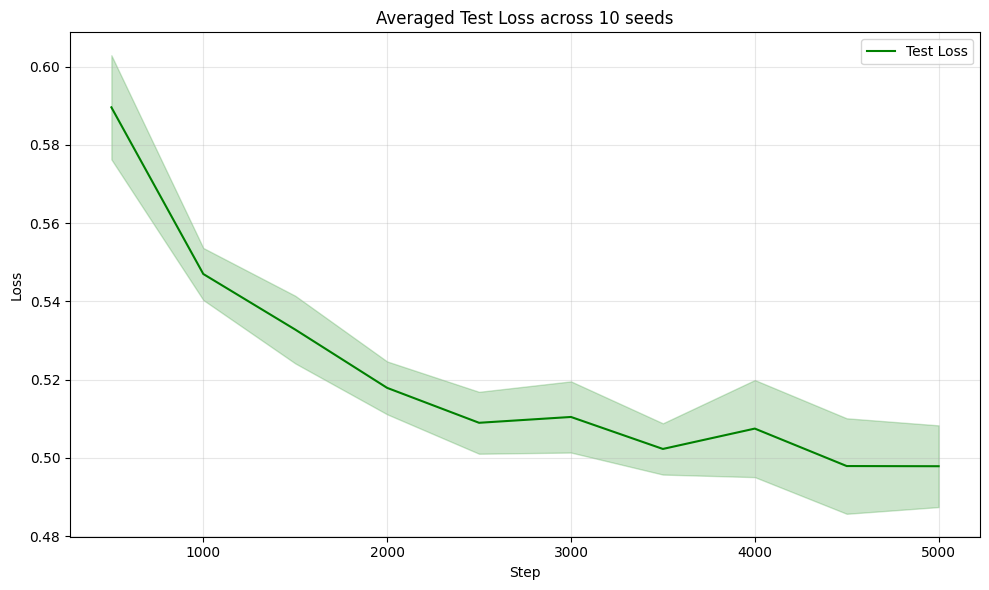

In [61]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_steps, test_mean, label='Test Loss', color='green')
ax.fill_between(test_steps, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Averaged Test Loss across 10 seeds')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('out/plots/test_loss.png', dpi=150)
plt.show()

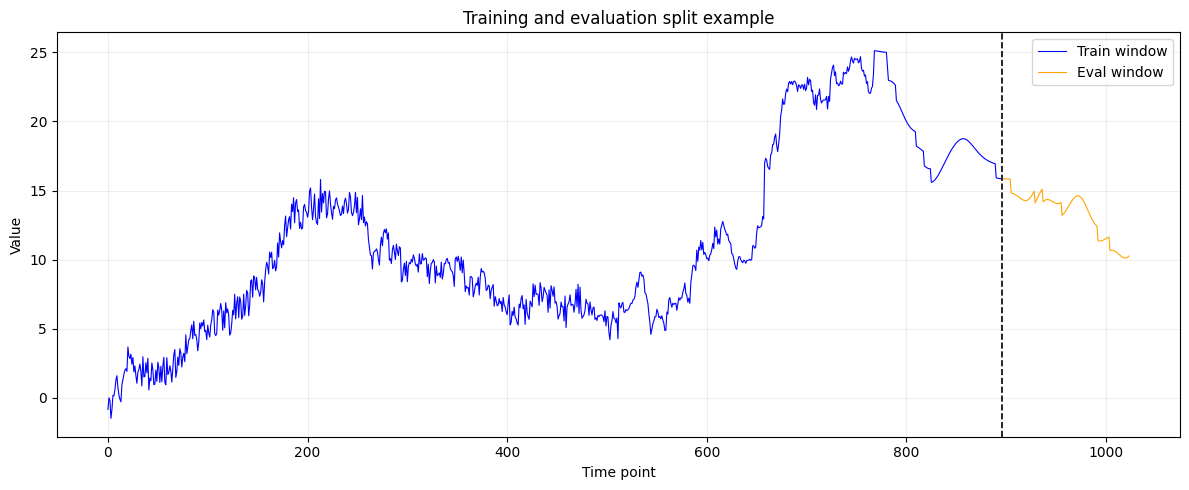

In [59]:
signal = samples["dgp_dataset"]["samples"][0]
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(range(896), signal[:896], color='blue', linewidth=0.8, label='Train window')
ax.plot(range(896, 1024), signal[896:1024], color='orange', linewidth=0.8, label='Eval window')
ax.axvline(x=896, color='black', linestyle='--', linewidth=1.2)
ax.set_xlabel('Time point')
ax.set_ylabel('Value')
ax.set_title('Training and evaluation split example')
ax.legend()
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('out/plots/signal_windows.png', dpi=150)
plt.show()

In [62]:
for step in steps:
    vals = test_losses_by_step[step]
    print(f"Step {step}: {np.mean(vals):.4f} ± {np.std(vals):.4f}")

Step 500: 0.5967 ± 0.0117
Step 1000: 0.5444 ± 0.0091
Step 1500: 0.5291 ± 0.0075
Step 2000: 0.5158 ± 0.0081
Step 2500: 0.5117 ± 0.0101
Step 3000: 0.5085 ± 0.0106
Step 3500: 0.5057 ± 0.0091
Step 4000: 0.4958 ± 0.0116
Step 4500: 0.4957 ± 0.0096
Step 5000: 0.4964 ± 0.0061
